In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
import numpy as np
import pandas as pd
from scipy.stats import scoreatpercentile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
#定义KS曲线
import matplotlib.pyplot as plt
def PlotKS(preds, labels, n, asc):
   
  # preds is score: asc=1
  # preds is prob: asc=0
   
  pred = preds # 预测值
  bad = labels # 取1为bad, 0为good
  ksds = pd.DataFrame({'bad': bad, 'pred': pred})
  ksds['good'] = 1 - ksds.bad
   
  if asc == 1:
    ksds1 = ksds.sort_values(by=['pred', 'bad'], ascending=[True, True])
  elif asc == 0:
    ksds1 = ksds.sort_values(by=['pred', 'bad'], ascending=[False, True])
  ksds1.index = range(len(ksds1.pred))
  ksds1['cumsum_good1'] = 1.0*ksds1.good.cumsum()/sum(ksds1.good)
  ksds1['cumsum_bad1'] = 1.0*ksds1.bad.cumsum()/sum(ksds1.bad)
   
  if asc == 1:
    ksds2 = ksds.sort_values(by=['pred', 'bad'], ascending=[True, False])
  elif asc == 0:
    ksds2 = ksds.sort_values(by=['pred', 'bad'], ascending=[False, False])
  ksds2.index = range(len(ksds2.pred))
  ksds2['cumsum_good2'] = 1.0*ksds2.good.cumsum()/sum(ksds2.good)
  ksds2['cumsum_bad2'] = 1.0*ksds2.bad.cumsum()/sum(ksds2.bad)
   
  # ksds1 ksds2 -> average
  ksds = ksds1[['cumsum_good1', 'cumsum_bad1']]
  ksds['cumsum_good2'] = ksds2['cumsum_good2']
  ksds['cumsum_bad2'] = ksds2['cumsum_bad2']
  ksds['cumsum_good'] = (ksds['cumsum_good1'] + ksds['cumsum_good2'])/2
  ksds['cumsum_bad'] = (ksds['cumsum_bad1'] + ksds['cumsum_bad2'])/2
   
  # ks
  ksds['ks'] =  ksds['cumsum_good']-ksds['cumsum_bad']
  ksds['tile0'] = range(1, len(ksds.ks) + 1)
  ksds['tile'] = 1.0*ksds['tile0']/len(ksds['tile0'])
   
  qe = list(np.arange(0, 1, 1.0/n))
  qe.append(1)
  qe = qe[1:]
   
  ks_index = pd.Series(ksds.index)
  ks_index = ks_index.quantile(q = qe)
  ks_index = np.ceil(ks_index).astype(int)
  ks_index = list(ks_index)
   
  ksds = ksds.loc[ks_index]
  ksds = ksds[['tile', 'cumsum_good', 'cumsum_bad', 'ks']]
  ksds0 = np.array([[0, 0, 0, 0]])
  ksds = np.concatenate([ksds0, ksds], axis=0)
  ksds = pd.DataFrame(ksds, columns=['tile', 'cumsum_good', 'cumsum_bad', 'ks'])
   
  ks_value = ksds.ks.max()
  ks_pop = ksds.tile[ksds.ks.idxmax()]
  print ('ks_value is ' + str(np.round(ks_value, 4)) + ' at pop = ' + str(np.round(ks_pop, 4)))
   
  # chart
  plt.plot(ksds.tile, ksds.cumsum_good, label='cum_good',
             color='blue', linestyle='-', linewidth=2)
              
  plt.plot(ksds.tile, ksds.cumsum_bad, label='cum_bad',
            color='red', linestyle='-', linewidth=2)
            
             
  plt.axvline(ks_pop, color='gray', linestyle='--')
  plt.axhline(ks_value, color='green', linestyle='--')
  plt.axhline(ksds.loc[ksds.ks.idxmax(), 'cumsum_good'], color='blue', linestyle='--')
  plt.axhline(ksds.loc[ksds.ks.idxmax(),'cumsum_bad'], color='red', linestyle='--')
  plt.title('KS=%s ' %np.round(ks_value, 4) +
        'at Pop=%s' %np.round(ks_pop, 4), fontsize=15)
   
 
  return ksds

# 读取数据

In [2]:
data =  pd.read_csv('train.csv')
data.head()

,MTH_TEL_BILL,als_m3_id_nbank_tot_mons,als_m12_id_bank_tot_mons,RACE,SINGE_DATE,BIRTHDAY,m1_num,als_lst_id_bank_inteday,als_lst_id_nbank_consnum,m6_num,...,m3_day,m3_num,MONTH_RATE,REPAY_DAY,als_m12_id_nbank_tot_mons,als_lst_id_bank_consnum,MTH_REPAY_AMT,als_m6_id_bank_tot_mons,d7_num,y
0,0,1,0,1,2,28,8,0,1,12.0,...,352,12.00,1.03,8,1,0,310,0,8,0
1,1,1,0,0,1,20,10,0,1,14.0,...,352,14.00,1.67,11,1,0,273,0,10,0
2,0,2,5,0,3,31,6,12,1,101.8,...,138,37.33,1.09,10,6,1,288,3,0,0
3,0,1,0,0,2,23,10,0,1,14.0,...,352,14.00,1.67,10,1,0,399,0,10,0
4,0,1,0,0,4,40,0,0,1,18.0,...,352,14.00,1.03,28,2,0,310,0,0,0


In [3]:
data.y.value_counts()

0    2656
1     344
Name: y, dtype: int64

# 特征工程

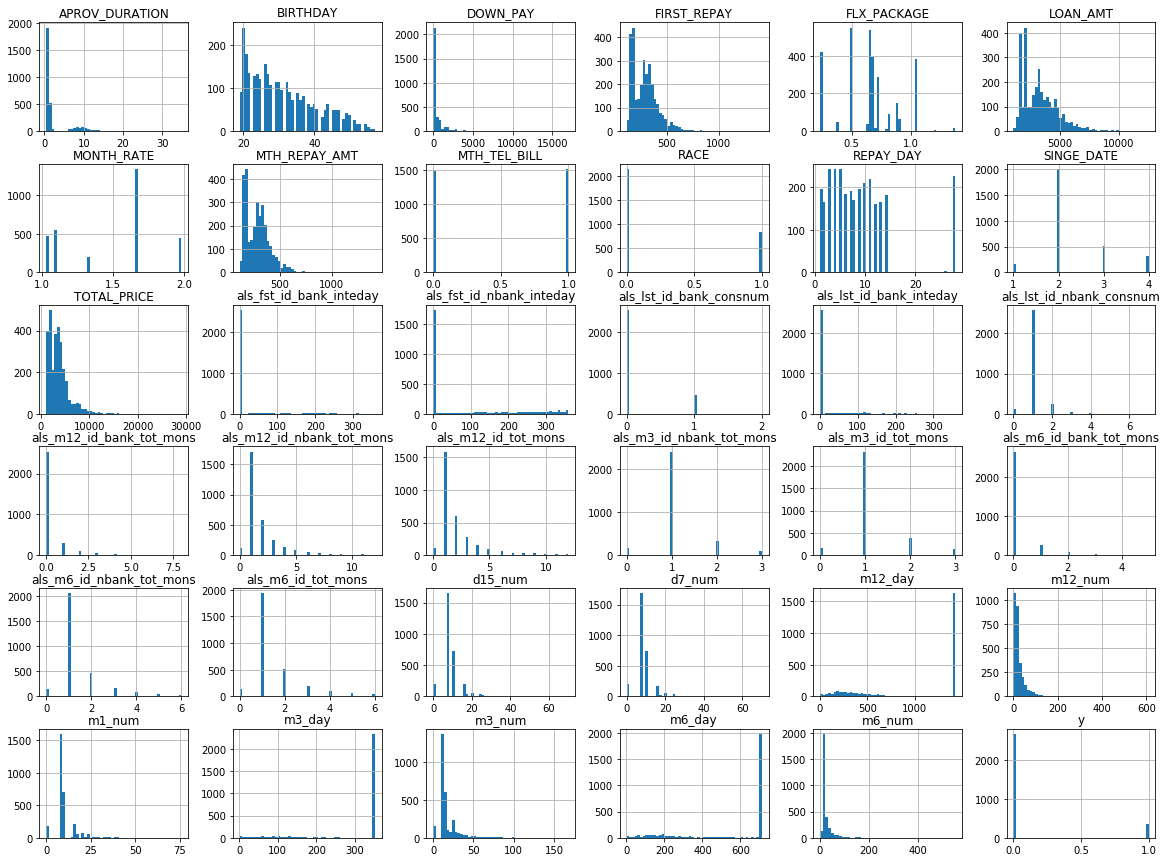

In [7]:
data.hist(figsize=(20, 15), bins=50, grid=True)
plt.show()

In [6]:
 continuous_cols = data.columns.values.tolist()
# for col in continuous_cols:
#     sns.jointplot(x=col, y="y", data=data, alpha=0.3, size=4)

C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


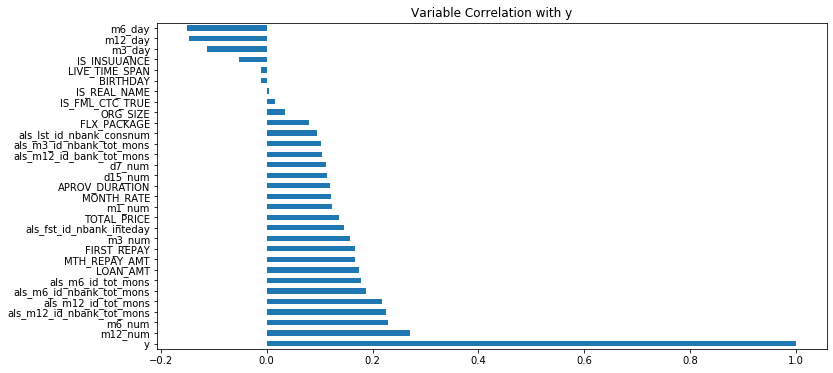

In [7]:
plt.figure(figsize=(12, 6))
data.corr()['y'][continuous_cols].sort_values(ascending=False).plot(
    'barh', figsize=(12, 6), title='Variable Correlation with y'
)

In [8]:
data = data.drop(['LIVE_TIME_SPAN','BIRTHDAY','IS_REAL_NAME','IS_FML_CTC_TRUE','ORG_SIZE','als_m3_id_nbank_tot_mons','als_m12_id_bank_tot_mons'],axis=1)

In [9]:
y = data['y']
X = data.drop(['y'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

In [10]:
bad = data.loc[(data['y'] == 1 )]
bad.head()

,y,als_fst_id_nbank_inteday,d7_num,als_m12_id_nbank_tot_mons,FIRST_REPAY,als_m12_id_tot_mons,FLX_PACKAGE,m12_num,m6_num,als_lst_id_nbank_consnum,...,als_m6_id_tot_mons,m6_day,APROV_DURATION,TOTAL_PRICE,MONTH_RATE,d15_num,m12_day,MTH_REPAY_AMT,m3_day,m1_num
5,1,180,16,3,463,3,0.65,66.00,33.0,3,...,2,190,0.73,8130,1.67,16,190,463,352,16
9,1,1,8,1,649,1,0.65,12.00,12.0,1,...,1,712,0.57,8490,1.67,8,1428,649,352,8
12,1,1,8,1,630,1,0.67,12.00,12.0,1,...,1,712,1.22,7831,1.67,8,1428,630,352,8
31,1,271,10,3,246,3,0.80,40.66,33.0,1,...,2,216,9.32,4243,1.33,10,368,246,88,18
35,1,1,30,1,395,1,0.65,42.00,42.0,3,...,1,712,1.32,7376,1.67,30,1428,395,352,30


In [11]:
bady = bad['y']
badX = bad.drop(['y'],axis=1)
vol = 120

In [12]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42)
X_test1 = X_train[0:vol]
y_test1 = y_train[0:vol]
X_smo, y_smo = smo.fit_sample(X_train, y_train)

In [13]:
X_test = X_test.append(X_test1).values
y_test = y_test.append(y_test1).values
# badX = badX.values
# bady = bady.values

# XGboost

In [14]:
data_train = xgb.DMatrix(X_smo,y_smo)  # 使用XGBoost的原生版本需要对数据进行转化
data_test = xgb.DMatrix(X_test,y_test)
 
param = {'max_depth':15 , 'eta': 1, 'objective': 'binary:logistic'}
watchlist = [(data_test, 'test'), (data_train, 'train')]
n_round = 18
booster = xgb.train(param, data_train, num_boost_round=n_round, evals=watchlist)

booster.get_fscore()

[0]	test-error:0.159722	train-error:0.061882
[1]	test-error:0.156944	train-error:0.031059
[2]	test-error:0.144444	train-error:0.017647
[3]	test-error:0.136111	train-error:0.010118
[4]	test-error:0.125	train-error:0.007294
[5]	test-error:0.131944	train-error:0.006118
[6]	test-error:0.129167	train-error:0.004
[7]	test-error:0.126389	train-error:0.003765
[8]	test-error:0.127778	train-error:0.003294
[9]	test-error:0.123611	train-error:0.002118
[10]	test-error:0.125	train-error:0.002353
[11]	test-error:0.123611	train-error:0.001647
[12]	test-error:0.123611	train-error:0.001412
[13]	test-error:0.127778	train-error:0.001647
[14]	test-error:0.125	train-error:0.001412
[15]	test-error:0.122222	train-error:0.001176
[16]	test-error:0.122222	train-error:0.001176
[17]	test-error:0.123611	train-error:0.000941


{'f7': 34,
 'f15': 292,
 'f8': 25,
 'f0': 79,
 'f5': 87,
 'f3': 175,
 'f9': 39,
 'f17': 62,
 'f19': 58,
 'f11': 134,
 'f16': 152,
 'f1': 49,
 'f6': 58,
 'f4': 11,
 'f2': 24,
 'f18': 19,
 'f10': 25,
 'f12': 21,
 'f14': 36,
 'f22': 20,
 'f21': 24,
 'f13': 9}

In [15]:
# 计算错误率
y_prob_1 = booster.predict(data_test)
y_label = data_test.get_label()
 
accuracy = sum(y_label == (y_prob_1 > 0.5))
accuracy_rate = float(accuracy) / len(y_prob_1)
# print ('样本总数：{0}'.format(len(y_predicted)))
# print ('正确数目：{0}'.format(accuracy) )
print ('Accuracy：{0:.3f}'.format((accuracy_rate)))

Accuracy：0.876


In [16]:
# bdata_train = xgb.DMatrix(Xs_train, ys_train)  # 使用XGBoost的原生版本需要对数据进行转化
# bdata_test = xgb.DMatrix(badX, bady)
 
# # param = {'max_depth':32 , 'eta': 1, 'objective': 'binary:logistic'}
# # watchlist = [(data_test, 'test'), (data_train, 'train')]
# # n_round = 30
# # booster = xgb.train(param, data_train, num_boost_round=n_round, evals=watchlist)
 
# # 计算错误率
# by_predicted = booster.predict(bdata_test)
# by_label = bdata_test.get_label()
 
# baccuracy = sum(by_label == (by_predicted > 0.5))
# baccuracy_rate = float(baccuracy) / len(by_predicted)
# print ('样本总数：{0}'.format(len(by_predicted)))
# print ('正确数目：{0}'.format(baccuracy) )
# print ('BADAccuracy：{0:.3f}'.format((baccuracy_rate)))

In [17]:
# print('我们的加权分:',(accuracy_rate+baccuracy_rate)/2)

In [18]:
from sklearn import metrics
print('AUC: %.4f' % metrics.roc_auc_score(y_label,y_prob_1))
#metrics.roc_curve(y_label, y_predicted, pos_label=None, sample_weight=None, drop_intermediate=True)
#print('ACC: %.4f' % metrics.accuracy_score(y_label,y_predicted))
from scipy.stats import ks_2samp
get_ks = lambda y_pred,y_true: ks_2samp(y_pred[y_true==1], y_pred[y_true!=1]).statistic
print('KS:',get_ks(y_prob_1,y_label))

AUC: 0.7291
KS: 0.4074902795099406


In [19]:
# from sklearn.metrics import roc_curve, auc  ###计算roc和auc
# # Compute ROC curve and ROC area for each class
# fpr,tpr,threshold = roc_curve(y_label, y_predicted) ###计算真正率和假正率
# roc_auc = auc(fpr,tpr) ###计算auc的值

# plt.figure()
# lw = 2
# plt.figure(figsize=(5,5))
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

ks_value is 0.3951 at pop = 0.8014


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tile,cumsum_good,cumsum_bad,ks
0,0.000000,0.000000,0.000000,0.000000
1,0.101389,0.105678,0.069767,0.035911
2,0.201389,0.214511,0.104651,0.109860
3,0.301389,0.324921,0.127907,0.197014
4,0.401389,0.430599,0.186047,0.244553
5,0.501389,0.534700,0.255814,0.278886
6,0.601389,0.641956,0.302326,0.339630
7,0.701389,0.742902,0.395349,0.347553
8,0.801389,0.848580,0.453488,0.395092
9,0.901389,0.940063,0.616279,0.323784


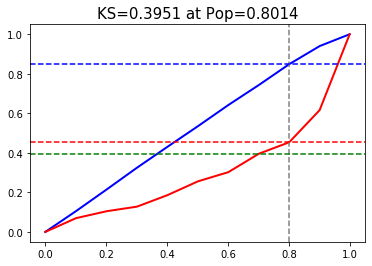

In [20]:
PlotKS(y_prob_1, y_label, 10, 1)#XGB的KS曲线

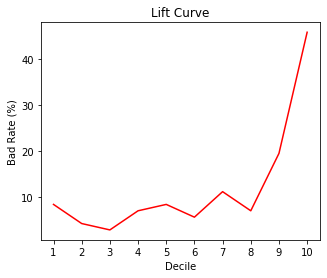

In [21]:
result = pd.DataFrame(y_label)
result['proba'] = pd.DataFrame(y_prob_1)

result.columns = ['target','proba']
result_ = result.copy()
proba_copy = result.proba.copy()
for i in range(10):
    point1 = scoreatpercentile(result_.proba, i*(100/10))
    point2 = scoreatpercentile(result_.proba, (i+1)*(100/10))
    proba_copy[(result_.proba >= point1) & (result_.proba <= point2)] = ((i+1))
result_['grade'] = proba_copy
df_gain = result_.groupby(by=['grade'], sort=True).sum()/(len(result)/10)*100
plt.plot(df_gain['target'], color='red')
# for xy in zip(df_gain['target'].reset_index().values):
#     plt.annotate("%s" % round(xy[0][1],2), xy=xy[0], xytext=(-20, 10), textcoords='offset points')  
plt.title('Lift Curve')
plt.xlabel('Decile')
plt.ylabel('Bad Rate (%)')
plt.xticks([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.show()

# 随机森林

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

In [23]:
rf = RandomForestClassifier(criterion='gini',n_estimators=40,max_depth=32)
rf.fit(X_smo,y_smo)

rf.feature_importances_

array([0.02639006, 0.03360796, 0.04175362, 0.05579731, 0.04197801,
       0.04243183, 0.07065565, 0.05934398, 0.04421995, 0.05577664,
       0.03344606, 0.05892007, 0.02288767, 0.02457881, 0.01496472,
       0.09806689, 0.05168667, 0.04829095, 0.03352616, 0.0188379 ,
       0.05341892, 0.01423872, 0.05518146])

In [24]:
y_pred_proba = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)
accuracy = sum(y_test == y_pred)
accuracy_rate = float(accuracy) / len(y_pred)
y_label = data_test.get_label()
# print ('样本总数：{0}'.format(len(y_pred)))
# print ('正确数目：{0}'.format(accuracy) )
print ('正确率：{0:.3f}'.format(accuracy_rate))

正确率：0.878


In [25]:
# by_pred_proba = rf.predict_proba(badX)
# by_pred = rf.predict(badX)
# baccuracy = sum(bady == by_pred)
# baccuracy_rate = float(baccuracy) / len(by_pred)
# by_label = data_test.get_label()
# print ('样本总数：{0}'.format(len(by_pred)))
# print ('正确数目：{0}'.format(baccuracy) )
# print ('正确率：{0:.3f}'.format(baccuracy_rate))

In [26]:
# print('我们的加权分:',(accuracy_rate+baccuracy_rate)/2)

In [27]:
proba2 = pd.DataFrame(y_pred_proba)
y_prob_2 = proba2[1].values
print('AUC: %.4f' % metrics.roc_auc_score(y_label,y_prob_2))

AUC: 0.7597


<Figure size 432x288 with 0 Axes>

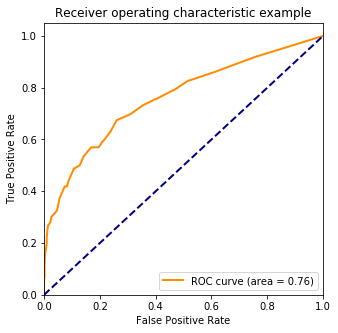

In [28]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_label, y_prob_2) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [29]:
from scipy.stats import ks_2samp
get_ks = lambda y_pred,y_true: ks_2samp(y_pred[y_true==1], y_pred[y_true!=1]).statistic
print('KS:',get_ks(y_prob_2,y_label))

KS: 0.4141662387205634


ks_value is 0.4017 at pop = 0.8014


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tile,cumsum_good,cumsum_bad,ks
0,0.000000,0.000000,0.000000,0.000000
1,0.101389,0.109621,0.040698,0.068924
2,0.201389,0.223186,0.040698,0.182488
3,0.301389,0.327287,0.110465,0.216822
4,0.401389,0.434543,0.156977,0.277566
5,0.501389,0.538644,0.226744,0.311899
6,0.601389,0.645899,0.273256,0.372643
7,0.701389,0.749211,0.348837,0.400374
8,0.801389,0.849369,0.447674,0.401695
9,0.901389,0.940063,0.616279,0.323784


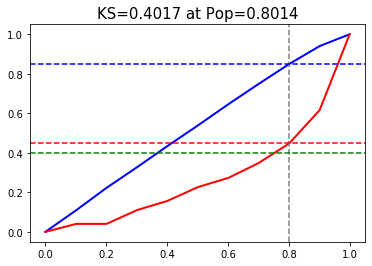

In [30]:
PlotKS(y_prob_2, y_label, 10, 1)#RF的KS曲线

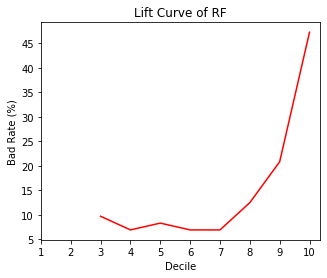

In [31]:
result = pd.DataFrame(y_label)
result['proba'] = pd.DataFrame(y_prob_2)

result.columns = ['target','proba']
result_ = result.copy()
proba_copy = result.proba.copy()
for i in range(10):
    point1 = scoreatpercentile(result_.proba, i*(100/10))
    point2 = scoreatpercentile(result_.proba, (i+1)*(100/10))
    proba_copy[(result_.proba >= point1) & (result_.proba <= point2)] = ((i+1))
result_['grade'] = proba_copy
df_gain = result_.groupby(by=['grade'], sort=True).sum()/(len(result)/10)*100
plt.plot(df_gain['target'], color='red')
# for xy in zip(df_gain['target'].reset_index().values):
#     plt.annotate("%s" % round(xy[0][1],2), xy=xy[0], xytext=(-20, 10), textcoords='offset points')  

plt.title('Lift Curve of RF')
plt.xlabel('Decile')
plt.ylabel('Bad Rate (%)')
plt.xticks([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.show()

# 逻辑回归

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 10)
lr.fit(X_smo, y_smo)
print('Training accuracy:', lr.score(X_smo, y_smo))
print('Test accuracy:', lr.score(X_test, y_test))

Training accuracy: 0.7254117647058823
Test accuracy: 0.7319444444444444


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
y_pred_3 = lr.predict(X_test)

# 投票 

In [34]:
bestaks = 0
for i in range(0,20):
    for j in range(0,20):
        a = 0.1*i
        b = 0.1*j
        c = 3-a-b
        y_pre = (a*y_prob_1 + b*y_prob_2 + c*y_pred_3 )/3
        ks = get_ks(y_pre,y_label)
        accuracy = sum(y_label == (y_pre > 0.5))
        accuracy_rate = float(accuracy) / len(y_pre)
        if (4*ks+accuracy_rate)  > bestaks:
            bestaks = 4*ks + 1*accuracy_rate
            besti = i
            bestj = j
besti,bestj

(12, 9)

In [35]:
y_pre = (0.1*besti*y_prob_1 + 0.1*bestj*y_prob_2 + 0.1*(30-besti-bestj)*y_pred_3 )/3
accuracy = sum(y_label == (y_pre > 0.5))
accuracy_rate = float(accuracy) / len(y_pre)
print('KS: %.4f' % get_ks(y_pre,y_label))
print ('Accuracy：{0:.3f}'.format((accuracy_rate)))
print('AUC: %.4f' % metrics.roc_auc_score(y_label,y_pre))

KS: 0.4690
Accuracy：0.868
AUC: 0.7499


<Figure size 432x288 with 0 Axes>

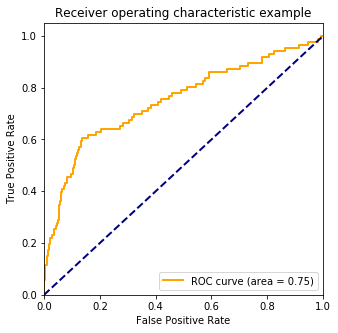

In [36]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_label, y_pre) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='orange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ks_value is 0.4611 at pop = 0.8014


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tile,cumsum_good,cumsum_bad,ks
0,0.000000,0.000000,0.000000,0.000000
1,0.101389,0.108833,0.046512,0.062321
2,0.201389,0.217666,0.081395,0.136270
3,0.301389,0.324921,0.127907,0.197014
4,0.401389,0.430599,0.186047,0.244553
5,0.501389,0.539432,0.220930,0.318502
6,0.601389,0.643533,0.290698,0.352835
7,0.701389,0.747634,0.360465,0.387169
8,0.801389,0.856467,0.395349,0.461118
9,0.901389,0.938486,0.627907,0.310579


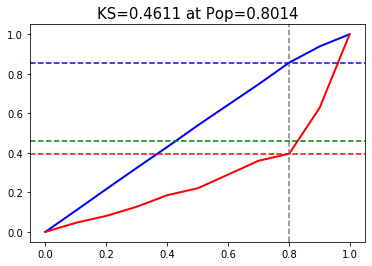

In [37]:
PlotKS(y_pre, y_label, 10, 1)#KS曲线

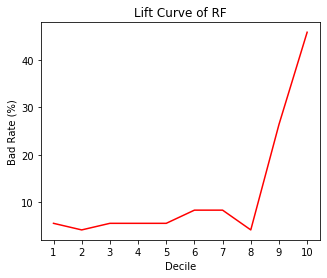

In [38]:
result = pd.DataFrame(y_label)
result['proba'] = pd.DataFrame(y_pre)

result.columns = ['target','proba']
result_ = result.copy()
proba_copy = result.proba.copy()
for i in range(10):
    point1 = scoreatpercentile(result_.proba, i*(100/10))
    point2 = scoreatpercentile(result_.proba, (i+1)*(100/10))
    proba_copy[(result_.proba >= point1) & (result_.proba <= point2)] = ((i+1))
result_['grade'] = proba_copy
df_gain = result_.groupby(by=['grade'], sort=True).sum()/(len(result)/10)*100
plt.plot(df_gain['target'], color='red')
# for xy in zip(df_gain['target'].reset_index().values):
#     plt.annotate("%s" % round(xy[0][1],2), xy=xy[0], xytext=(-20, 10), textcoords='offset points')  

plt.title('Lift Curve of RF')
plt.xlabel('Decile')
plt.ylabel('Bad Rate (%)')
plt.xticks([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.show()

In [1]:
data1 = [0., 0., 0., 0., 0., 0.,1., 1., 1., 1., 1., 1.]
data2 = [0.3,0.4,0.6,0.2,0.7,0.5,0.1,0.9,0.7,0.5,0.9,0.8]
from sklearn import metrics
print('AUC: %.4f' % metrics.roc_auc_score(data1,data2))

AUC: 0.7500
